In [49]:
%load_ext autoreload
%autoreload 2

In [50]:
import torch
from hessian_eigenthings import compute_hessian_eigenthings
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
num_samples = 100
num_features = 20
torch.manual_seed(0)
X = torch.normal(0, 1, size=(num_samples, num_features))
y = torch.normal(0, 1, size = (num_samples,1))

In [31]:
def loss_fn(model, inputs):
    
    X, y = inputs
    preds = model(X)
    
    return torch.nn.MSELoss(reduction='mean')(y, preds)

In [32]:
class Network(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(20, 1, bias=False)

        
    def forward(self,x):

        x = self.fc1(x)        
        return x

In [33]:
linear_model = Network()
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(linear_model.parameters(), lr=0.005, momentum=0.9)
trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=10,shuffle=True)

In [34]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = linear_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    if epoch%2 == 0:
        PATH = 'linear_model_iter' + str(epoch)
        torch.save(linear_model.state_dict(), PATH)

    print(f'epoch: {epoch+1}, loss:{running_loss/10}')

print('Finished Training')

epoch: 1, loss:1.3953729152679444
epoch: 2, loss:0.8416316092014313
epoch: 3, loss:0.7365480333566665
epoch: 4, loss:0.6948307290673256
epoch: 5, loss:0.6917983621358872
epoch: 6, loss:0.7094778060913086
epoch: 7, loss:0.6811734229326248
epoch: 8, loss:0.6916397541761399
epoch: 9, loss:0.681044689565897
epoch: 10, loss:0.6882122218608856
Finished Training


In [43]:
num_eigenthings = 20

eigenvals_dict = {}
eigenvecs_dict = {}

for i in range(0, 10, 2):
    
    PATH = 'linear_model_iter' + str(i)
    linear_model = Network()
    linear_model.load_state_dict(torch.load(PATH))
    eigenvals, eigenvecs = compute_hessian_eigenthings(linear_model, trainloader,criterion, num_eigenthings, use_gpu=False)  
    eigenvals_dict[i] = eigenvals
    eigenvecs_dict[i] = eigenvecs
    h = np.matmul(np.matmul(eigenvecs.T, np.diag(eigenvals)), eigenvecs)
    

 [=============================================================>...]  Step: 14ms | Tot: 259ms | power iter error: 0.00 20/20 
 [=============================================================>...]  Step: 13ms | Tot: 263ms | power iter error: 0.00 20/20 
 [=============================================================>...]  Step: 13ms | Tot: 256ms | power iter error: 0.00 20/20 
 [=============================================================>...]  Step: 13ms | Tot: 260ms | power iter error: 0.00 20/20 
 [=============================================================>...]  Step: 13ms | Tot: 257ms | power iter error: 0.00 20/20 =======================================>.........................]  Step: 24ms | Tot: 178ms | power iter error: 0.00 13/20 
 [=============================================================>...]  Step: 13ms | Tot: 260ms | power iter error: 0.00 20/20 
 [=============================================================>...]  Step: 13ms | Tot: 256ms | power iter error: 0.00 20

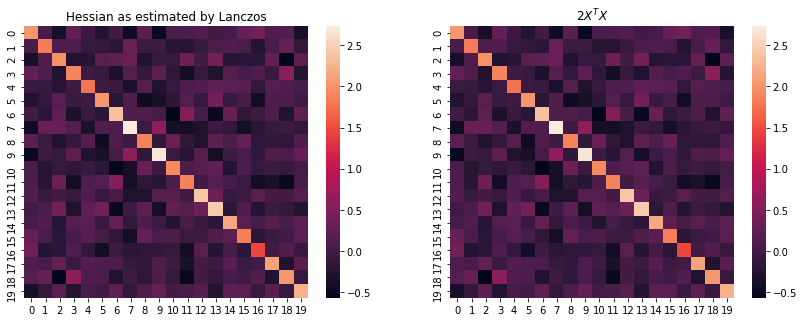

In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
H = h#torch.matmul(torch.matmul(V, T).T, V)
plt.title("Hessian as estimated by Lanczos")
sns.heatmap(H)
plt.subplot(1,2,2)
plt.title("$2X^TX$")
sns.heatmap(2 * torch.matmul(X.T, X)/X.shape[0])
plt.show()

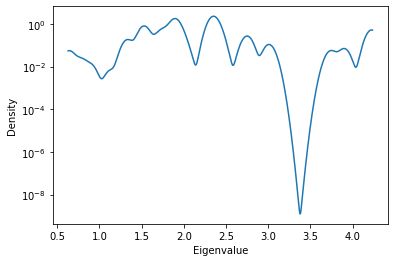

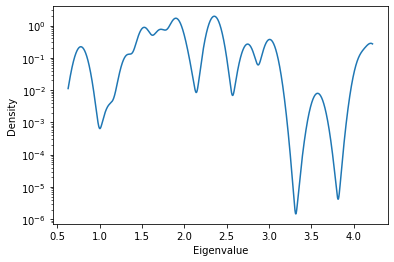

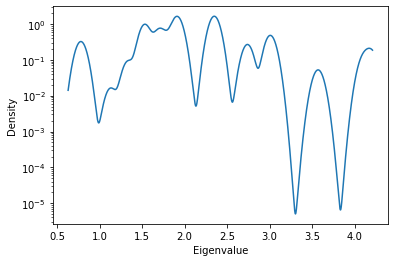

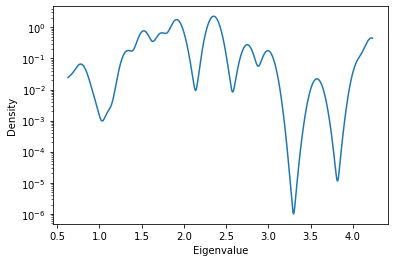

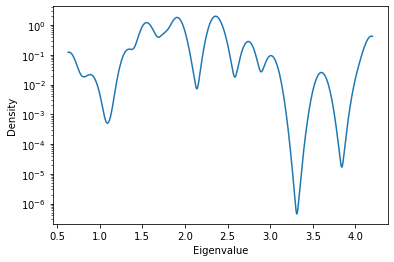

In [56]:
import density as density_lib
def plot(grids, density, label=None):
    
    plt.semilogy(grids, density, label=label)
    plt.ylabel("Density")
    plt.xlabel("Eigenvalue")
    plt.show()



for i in range(0, 10, 2):

    density, grids = density_lib.tridiag_to_density(eigenvals_dict[i], eigenvecs_dict[i], grid_len=10000, sigma_squared=1e-3)

    plot(grids, density)